In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN

In [68]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [69]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

In [70]:
# To see unique values per column. 
[{col: train[col].nunique() for col in train.columns}], train.shape

([{'id': 8631,
   'Administrative': 27,
   'Administrative_Duration': 2542,
   'Informational': 14,
   'Informational_Duration': 978,
   'ProductRelated': 277,
   'ProductRelated_Duration': 6955,
   'BounceRates': 1440,
   'ExitRates': 3553,
   'PageValues': 1889,
   'SpecialDay': 6,
   'Month': 10,
   'OperatingSystems': 8,
   'Browser': 13,
   'Region': 9,
   'TrafficType': 20,
   'VisitorType': 3,
   'Weekend': 2,
   'revenue': 2}],
 (8631, 19))

In [71]:
print(train.columns)
print(train.info())

Index(['id', 'Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'revenue'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8631 entries, 0 to 8630
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       8631 non-null   int64  
 1   Administrative           8631 non-null   int64  
 2   Administrative_Duration  8631 non-null   float64
 3   Informational            8631 non-null   int64  
 4   Informational_Duration   8631 non-null   float64
 5   ProductRelated           8631 non-null   int64  
 6   ProductRelated_Duration  8631 non-null   float64
 7   BounceRates              8631 non-null   float6

In [72]:
def train_ordinal(df, enc_columns):
    """ Train an ordinal encoder from sklearn
    """
    enc = OrdinalEncoder()
    enc.fit(df[enc_columns].to_numpy())
    
    return enc

def transform_ordinal(df, enc, enc_columns):
    """ Transform and Apply an ordinal encoder from sklearn
    """
    df[enc_columns] = enc.transform(df[enc_columns])
    df[enc_columns] = df[enc_columns].astype('category')
    

In [73]:

def train_ohe(df, ohe_columns):
    """ Train a one hot encoder from sklearn
    """
    ohe = OneHotEncoder()
    ohe.fit(df[ohe_columns])
    return ohe

def transform_one_hot(df, ohe, ohe_columns):
    """ Transform and Apply an one-hot encoder from sklearn
    """
    df.loc[:, ohe.get_feature_names(ohe_columns)] = ohe.transform(df[ohe_columns]).toarray()
    df.drop(columns=ohe_columns, inplace=True)


In [74]:
def train_stdscaler(df, columns):
    """ Train a scaler from sklearn. MixMax gives better performance than StandardScaler
    """
    scaler = MinMaxScaler()
    scaler.fit(df[columns])
    return scaler

def transform_stdscaler(df, scaler, columns):
    """ Transform and Apply scaler from sklearn
    """
    df[columns] = scaler.transform(df[columns])
    

In [75]:
def sum_duration_columns(df):
    """ From all *_Duration columns, it are sum and result in a new column Total
    """
    duration_columns = df.columns.str.contains("Duration")
    # train["Total_Duration"] = 
    df['Total_Duration'] = df.loc[:,duration_columns].sum(axis=1)

def avg_duration_per_page(df):
    """ From all *_Duration columns, add a avg duration time per page
    """
    duration_columns = df.columns.str.contains("Duration")
    duration_columns_str = df.columns[duration_columns]
    pages_names = duration_columns_str.str.replace('_Duration', '')
    for page, duration in zip(pages_names, duration_columns_str):
        df[page+"_Duration_AVG"]= (df[duration] / df[page]).fillna(-1)


In [76]:
%%script false --no-raise-error
# I skip this part due to one-hot. LightGBM performs better with categorical feature treatment ad-hoc

# 1st option
enc_columns=["Month", "TrafficType", "Browser"]
enc = train_ordinal(train, enc_columns)
transform_ordinal(train, enc, enc_columns)

ohe_columns = ["SpecialDay", "OperatingSystems", "Region", "VisitorType", "Weekend"]
ohe = train_ohe(train, ohe_columns)
transform_one_hot(train, ohe, ohe_columns)

avg_duration_per_page(train)
sum_duration_columns(train)

stdscaler_columns = ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]

scaler = train_stdscaler(train, stdscaler_columns)
transform_stdscaler(train, scaler, stdscaler_columns)

In [77]:
# 2nd option
enc_columns=["Month", "TrafficType", "Browser", "SpecialDay", "OperatingSystems", "Region", "VisitorType", "Weekend"]
enc = train_ordinal(train, enc_columns)
transform_ordinal(train, enc, enc_columns)

avg_duration_per_page(train)
sum_duration_columns(train)

stdscaler_columns = ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]

scaler = train_stdscaler(train, stdscaler_columns)
transform_stdscaler(train, scaler, stdscaler_columns)

In [78]:
%%script false --no-raise-error
# transform test dataset with 1st option
transform_ordinal(test, enc, enc_columns)
transform_one_hot(test, ohe, ohe_columns)
sum_duration_columns(test)
transform_stdscaler(test, scaler, stdscaler_columns)

avg_duration_per_page(test)
sum_duration_columns(test)

In [79]:
# transform test dataset with 2nd option
transform_ordinal(test, enc, enc_columns)
transform_stdscaler(test, scaler, stdscaler_columns)
avg_duration_per_page(test)
sum_duration_columns(test)

In [80]:
# imblearn 
X, y = train.loc[:,~train.columns.isin(['revenue'])], train.revenue

In [81]:
oversampler = ADASYN() #SMOTE()

oversampler.fit(X, y)

X_hat, y_hat = oversampler.fit_resample(X, y)

<AxesSubplot:>

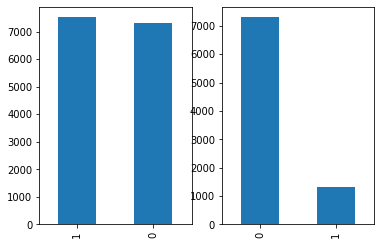

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2)
y_hat.value_counts().plot.bar(ax = ax1)
y.value_counts().plot.bar(ax = ax2)

In [83]:
avoid_resample = True
# if true, it doesn't apply resampling. 
# at the moment, model performs ok without resampling.

if not avoid_resample:
    train_transformed = pd.concat([X_hat, y_hat], axis=1)
    test_transformed = test.copy()
else:
    test_transformed = test.copy()
    train_transformed = train.copy()
    


In [84]:
train_transformed.to_parquet('../data/processed/train.parquet')
test_transformed.to_parquet('../data/processed/test.parquet')

In [52]:
train.dtypes

id                                int64
Administrative                    int64
Administrative_Duration         float64
Informational                     int64
Informational_Duration          float64
ProductRelated                    int64
ProductRelated_Duration         float64
BounceRates                     float64
ExitRates                       float64
PageValues                      float64
SpecialDay                     category
Month                          category
OperatingSystems               category
Browser                        category
Region                         category
TrafficType                    category
VisitorType                    category
Weekend                        category
revenue                           int64
Administrative_Duration_AVG     float64
Informational_Duration_AVG      float64
ProductRelated_Duration_AVG     float64
Total_Duration                  float64
dtype: object